In [1]:
from collections import namedtuple
from functools import partial
from itertools import cycle
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

# Set plotting style
sns.set_style("white")

%matplotlib inline

## Read in the data

In [2]:
# Read in all the data, which is split by year, and combine into a single dataframe
dfs = []
for year in range(1880, 2017):
    csv = "./data/nationwide/yob{year}.txt".format(year=year)
    df = pd.read_csv(csv, header=None, names=["name", "gender", "count"])
    df["year"] = year
    
    # Normalize by the the number of all children
    year_sum = df["count"].sum()
    df["fraction"] = df["count"] / year_sum
    
    # Normalize girls and boys seperately
    grouped_sum = df.groupby("gender")["count"].sum()
    df["girl fraction"] = df["count"] / grouped_sum['F']
    df["boy fraction"] = df["count"] / grouped_sum['M']
    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

del dfs  # Try to save some memory

In [3]:
NameTuple = namedtuple('NameTuple', ['name', 'gender'])
LineTuple = namedtuple('LineTuple', ['xs', 'ys', 'name'])

In [4]:
def draw_year_bands(ax, width=10):
    """Add grey bands to the plot with a sepcified width.
    
    Args:
        ax: a matplotlib axes object
        width (int, default 10): the width of the band in years
        
    """
    for start in range(1880+width, 2020, 2*width):
        end = start + width
        plt.axvspan(start, end, color="0.95", zorder=-2)

In [5]:
def calculate_top_names_by_gender(df, gender):
    """Finds the top name for each year in the dataframe.

    The names are returned in order from first year to last, and duplicates are
    removed.

    Args:
        df (dataframe): a dataframe with columns "year", "gender", and "count"
        gender (str): the gender to match in the gender column

    Returns:
        list (str): a list containing the top names ordered by year

    """
    gendered_df = df[df["gender"] == gender]
    max_locations = gendered_df.groupby("year")["count"].idxmax()
    max_df = gendered_df.loc[max_locations]
    
    return max_df["name"].unique()

In [6]:
def create_placeholder_artists(names):
    """ Create the artists that are going to be updated during the aviation.

    One artist is created for each nametuple in the list passed in.

    Args:
        names (list): an iterable of nametuples

    """
    palette = cycle(sns.color_palette())

    artists = []
    for nametuple in names:
        line = plt.plot([], [], color=next(palette), animated=True, label=nametuple.name)
        artists.append(line)

    return artists

In [7]:
def draw_legend(plt):
    """Draw the legend on the specified plot.

    Args:
        plt (matplotlib.pyplot): pyplot object

    """
    leg = plt.legend(
        loc="upper right",
        fontsize=18,
        ncol=2,
        frameon=1,
        fancybox=True,
        # The bellow commands remove the lines in the legend
        handlelength=0,
        handletextpad=0,
        markerscale=0,
    )

    # Turn on and theme the frame
    frame = leg.get_frame()
    frame.set_linewidth(1)
    frame.set_alpha(1)
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

    # Set the legend text color to match the line color
    handles, _ = ax.get_legend_handles_labels()
    texts = leg.get_texts()
    for handle, text in zip(handles, texts):
        text.set_color(handle.get_color())

    fig.tight_layout()

In [8]:
def init_fig(names, title, y_label, fig, ax, artists):
    """Initialize the figure, used to draw the first frame for the animation.

    Because this function must return a list of artists to be modified in the
    animation, a list is passed in and returned without being used or altered.

    Args:
        names (list): an iterable of nametuples
        title (str): the title of the plot
        fig (matplotlib figure): a matplotlib figure object
        ax (matplotlib axis): a matplotlib axis object
        artists: a list of artist objects

    Returns:
        list: the unaltered artists input

    """
    ax.set_title(title, fontsize=22)
    ax.set_ylabel(y_label, fontsize=20)

    draw_year_bands(ax, 5)

    plt.xlim(1880, 2016)
    plt.ylim(0, 0.09)

    plt.tick_params(axis='x', which='major', labelsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

    # Format the y-axis tick markers are percentage
    ax.yaxis.set_major_formatter(ticker.FuncFormatter('{0:.0%}'.format))

    draw_legend(plt)

    # Must return the list of artists, but we use a pass through so that they
    # aren't created multiple times
    return artists

In [9]:
def zero_fill_missing_years(years, counts, first_year, last_year):
    """Fill a count and date vector so that all missing entries are zeroed out.
    
    Args:
        years (list): a list of years as integers; must be the same size as counts
        counts (list): a list of counts as integers; must be the same size as years
        first_year (int): the year to start the filling process
        last_year (int): the year to stop after filling
        
    Returns:
        numpy array: years with the missing years filled in
        numpy array: counts with missing counts filled with 0
        
    """
    # Create a dictionary for fast look up of counts
    year_to_count = {}
    for year, count in zip(years, counts):
        year_to_count[year] = count
    
    # Make a new set of lists with 0 counts for missing years
    new_years = []
    new_counts = []
    for year in range(first_year, last_year+1):
        new_years.append(year)
        if year in year_to_count:
            new_counts.append(year_to_count[year])
        else:
            new_counts.append(0)
    
    return np.array(new_years), np.array(new_counts)

In [10]:
def generate_line(df, nametuple, first_year, last_year):
    """Returns a LineTuple for a given NameTuple with missing years zero
    padded.

    Args:
        df (dataframe): a dataframe with columns "year", "gender", and "count"
        nametuple (nametuple): a name tuple indicating the name and gender to
            generate a line for
        first_year (int): the year to start the line at
        last_year (int): the year to stop after

    Returns:
        LineTuple: contains the years and percent of all births
        
    """
    # Select the rows of the data frame
    name_match   = df["name"]==nametuple.name
    gender_match = df["gender"]==nametuple.gender
    selected_df = df[name_match & gender_match]
    selected_df.sort_values("year")

    # Get the year values for the x-axis
    years = selected_df["year"].as_matrix()

    # Get the percentage for column based on gender for the y-axis
    if nametuple.gender == "M":
        fraction_col = "boy fraction"
    else:
        fraction_col = "girl fraction"
    counts = selected_df[fraction_col].as_matrix()

    # Fill in missing years with zeroes so that there are no gaps in the line
    # that are interpolated
    new_years, new_counts = zero_fill_missing_years(years, counts, first_year, last_year)

    return LineTuple(new_years, new_counts, nametuple.name)

In [11]:
def step_lines_through_time(df, nametuples, first_year=1880, last_year=2016):
    """Creates a set of lines, one for each name in the nametuples, and steps
    them year by year, adding a data point each time.


    Args: 
        years (list): a list of years as integers; must be the same size as counts
        nametuples (list of nametuples): a list of nametuples, one for each line to draw.
        first_year (int): the year to start the line at
        last_year (int): the year to stop after

    Yields:
        list of LineTuples: a list of linetuples where each iteration another
            data point is added to all the lines.

    """
    # Create a line for each nametuple
    gl = partial(generate_line, first_year=first_year, last_year=last_year)
    lines = [gl(df, nt) for nt in nametuples]

    # Add one data point to each line, yield, and then repeat
    return_lines = []
    max_length = len(lines[0][0])
    for end_point in range(max_length):
        for i, linetuple in enumerate(lines):
            xs, ys, name = linetuple
            try:
                return_lines[i] = LineTuple(xs[:end_point+1], ys[:end_point+1], name)
            except IndexError:
                return_lines.append(LineTuple(xs[:end_point+1], ys[:end_point+1], name))
        yield return_lines

In [12]:
def generate_plot(lines, artists):
    """Update artists with data from linetuples.

    Args:
        lines (list of LineTuples): a list of linetuples to get data from
        artists (list of Artists): a list of artists to update
    """
    for i, line in enumerate(lines):
        artist = artists[i]
        if line is not None:
            xs, ys, name = line
            artist[0].set_data(xs, ys)

In [13]:
men_names = [NameTuple(name, "M") for name in calculate_top_names_by_gender(df, 'M')]

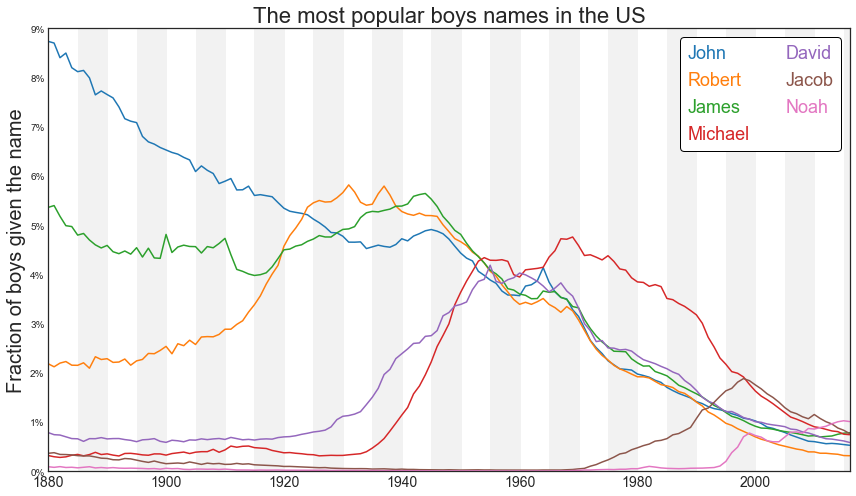

In [14]:
# Animate the Men Chart
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()

artists = create_placeholder_artists(men_names)

init = partial(init_fig, names=men_names, title="The most popular boys names in the US", y_label="Fraction of boys given the name", fig=fig, ax=ax, artists=artists)
generate = partial(generate_plot, artists=artists)

anim = animation.FuncAnimation(
    fig=fig,
    func=generate,
    frames=step_lines_through_time(df, men_names),
    init_func=init,
    save_count=(2016-1879)*len(men_names),
    repeat_delay=1000,
)

anim.save('/tmp/most_popular_us_boy_names.mp4', fps=18, extra_args=['-vcodec', 'libx264'], dpi=300)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/most_popular_us_boy_names.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()

In [15]:
women_names = [NameTuple(name, "F") for name in calculate_top_names_by_gender(df, 'F')]

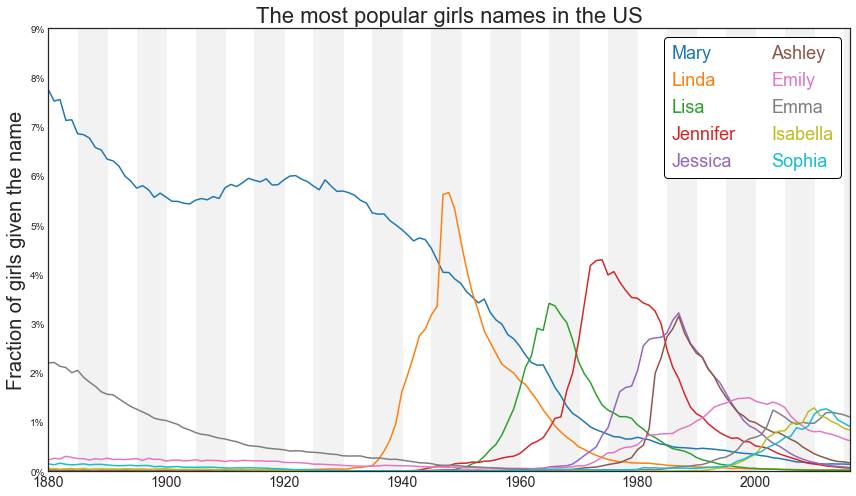

In [16]:
# Animate the Women Chart
fig = plt.figure(figsize=(12, 7))
ax = plt.gca()

artists = create_placeholder_artists(women_names)

init = partial(init_fig, names=men_names, title="The most popular girls names in the US",  y_label="Fraction of girls given the name", fig=fig, ax=ax, artists=artists)
generate = partial(generate_plot, artists=artists)

anim = animation.FuncAnimation(
    fig=fig,
    func=generate,
    frames=step_lines_through_time(df, women_names),
    init_func=init,
    save_count=(2016-1879)*len(men_names),
    repeat_delay=1000,
)

anim.save('/tmp/most_popular_us_girl_names.mp4', fps=18, extra_args=['-vcodec', 'libx264'], dpi=300)

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/most_popular_us_girl_names.{ext}".format(ext=ext), bbox_inches="tight")
    
plt.show()